In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [75]:
%%time
features = pd.read_csv('features.csv', sep='\t')
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
features.head()

CPU times: user 1min 34s, sys: 12.4 s, total: 1min 46s
Wall time: 2min 20s


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [77]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [66]:
%%time

# train['buy_time'] = pd.to_datetime(train['buy_time'], unit='s')
# test['buy_time'] = pd.to_datetime(test['buy_time'], unit='s')
# features['buy_time'] = pd.to_datetime(features['buy_time'], unit='s')
#
# train_merged = pd.merge_asof(train.sort_values('buy_time'),
#                        features.sort_values('buy_time'),
#                        by='id',
#                        on='buy_time',
#                        direction='backward')
#
# test_merged = pd.merge_asof(test.sort_values('buy_time'),
#                              features.sort_values('buy_time'),
#                              by='id',
#                              on='buy_time',
#                              direction='backward')

# train_merged = reduce_mem_usage(train_merged)
# test_merged = reduce_mem_usage(test_merged)#

# train_merged.info()
# test_merged.info()
# test_merged.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 259 entries, Unnamed: 0_x to 252
dtypes: float64(256), int64(3)
memory usage: 1.6 GB
CPU times: user 15.3 s, sys: 24.9 s, total: 40.2 s
Wall time: 2min 23s


In [78]:
train_merged_nearest = pd.merge_asof(train.sort_values('buy_time'),
                             features.sort_values('buy_time'),
                             by='id',
                             on='buy_time',
                             direction='nearest')

test_merged_nearest  = pd.merge_asof(test.sort_values('buy_time'),
                            features.sort_values('buy_time'),
                            by='id',
                            on='buy_time',
                            direction='nearest')

train_merged_nearest.isnull().sum()

Unnamed: 0_x    0
id              0
vas_id          0
buy_time        0
target          0
               ..
248             0
249             0
250             0
251             0
252             0
Length: 259, dtype: int64

In [79]:
train_merged_nearest.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
test_merged_nearest.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
test_merged_nearest.head(2)

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,1546808400,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,-16.08618,...,-464.373846,-104.770792,-25.996269,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0
1,31619,2.0,1546808400,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [80]:
train_merged_nearest = reduce_mem_usage(train_merged_nearest)
test_merged_nearest = reduce_mem_usage(test_merged_nearest)

Memory usage of dataframe is 1637.01 MB
Memory usage after optimization is: 821.68 MB
Decreased by 49.8%
Memory usage of dataframe is 139.67 MB
Memory usage after optimization is: 70.10 MB
Decreased by 49.8%


### Определение типов признаков

Для того, чтобы обработать признаки, нужно определить их типы.

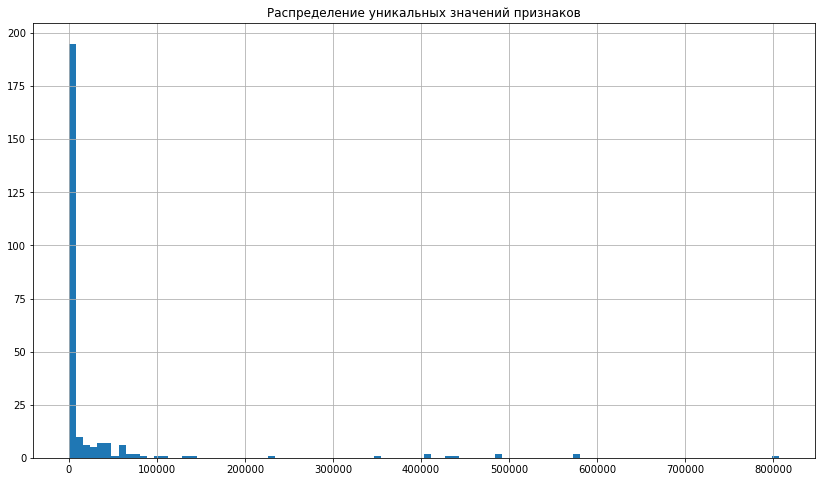

In [81]:
X_nunique = train_merged_nearest.apply(lambda x: x.nunique(dropna=False))

plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(14, 8));

In [101]:
# всего призков (удалим из них buy_time, id, target, vas_id)
all = set(X_nunique.index.tolist()[4:])
len(all), all

(253,
 {'0',
  '1',
  '10',
  '100',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '11',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '12',
  '120',
  '121',
  '122',
  '123',
  '124',
  '125',
  '126',
  '127',
  '128',
  '129',
  '13',
  '130',
  '131',
  '132',
  '133',
  '134',
  '135',
  '136',
  '137',
  '138',
  '139',
  '14',
  '140',
  '141',
  '142',
  '143',
  '144',
  '145',
  '146',
  '147',
  '148',
  '149',
  '15',
  '150',
  '151',
  '152',
  '153',
  '154',
  '155',
  '156',
  '157',
  '158',
  '159',
  '16',
  '160',
  '161',
  '162',
  '163',
  '164',
  '165',
  '166',
  '167',
  '168',
  '169',
  '17',
  '170',
  '171',
  '172',
  '173',
  '174',
  '175',
  '176',
  '177',
  '178',
  '179',
  '18',
  '180',
  '181',
  '182',
  '183',
  '184',
  '185',
  '186',
  '187',
  '188',
  '189',
  '19',
  '190',
  '191',
  '192',
  '193',
  '194',
  '195',
  '196',
  '197',
  '198',
  '199',


In [102]:
#Константные признаки (принимают только одно значение - их можно удалить)
const = set(X_nunique[X_nunique == 1].index.tolist())
len(const)

5

In [103]:
# Числовые признаки
numeric = (train_merged_nearest.fillna(0).astype(int).sum() - train_merged_nearest.fillna(0).sum()).abs()
numeric = set(numeric[numeric > 0].index.tolist())
len(numeric)

247

In [104]:
other = all - (numeric | const)
len(other), other,

(1, {'252'})

In [105]:
# Бинарные признаки
binary = set(train_merged_nearest.loc[:, other].columns[(
        (train_merged_nearest.loc[:, other].max() == 1) &
        (train_merged_nearest.loc[:, other].min() == 0) &
        (train_merged_nearest.loc[:, other].isnull().sum() == 0))])
len(binary)

0

In [111]:
# Категориальные признаки
categorical = set(X_nunique.loc[other][X_nunique.loc[other] <= 30].index.tolist())
numeric_extra = categorical

len(categorical)

1

In [115]:
other = other - categorical
numeric = numeric | other

In [118]:
print('Всего признаков (из них было удалено 4):', train_merged_nearest.shape[1] - 4)
print('Константные признаки:', len(const))
print('Бинарные признаки:', len(binary))
print('Категориальные:', len(categorical))
print('Вещественные признаки:', len(numeric))

Всего признаков (из них было удалено 4): 253
Константные признаки: 5
Бинарные признаки: 0
Категориальные: 1
Вещественные признаки: 247


In [112]:
# этот признак либо обработать до бинарного, либо удалить, так как он не разделяет классы
train_merged_nearest['252'].value_counts()

0.0       620787
1.0       210823
2.0            5
10.0           3
8.0            3
3.0            3
7.0            2
13.0           2
5.0            2
4.0            2
11.0           2
68.0           1
182.0          1
19.0           1
299.0          1
284.0          1
18.0           1
24.0           1
195.0          1
84.0           1
44.0           1
42.0           1
77.0           1
16.0           1
6.0            1
283.0          1
251.0          1
223.0          1
1743.0         1
22.0           1
Name: 252, dtype: int64

### Уменьшение размеров датасета
Уменьшим объем занимаемой памяти датасета с помощью функции, которая преобразовывает типы данных, а также уменьшим количество признаков с помощью метода главных компонент (PCA), предварительно отмасштабировав признаки, которые будем сжимать.

In [119]:
train_merged_nearest = reduce_mem_usage(train_merged_nearest)
test_merged_nearest = reduce_mem_usage(test_merged_nearest)

Memory usage of dataframe is 821.68 MB
Memory usage after optimization is: 821.68 MB
Decreased by 0.0%
Memory usage of dataframe is 70.10 MB
Memory usage after optimization is: 70.10 MB
Decreased by 0.0%


In [134]:
# Масштабирование вещественных признаков с помощью StandardScaler
numeric = list(numeric)
const = list(const)

train_merged_nearest_scaled = train_merged_nearest.copy()
test_merged_nearest_scaled = test_merged_nearest.copy()

scaler = StandardScaler()
train_merged_nearest_scaled[numeric] = scaler.fit_transform(train_merged_nearest_scaled[numeric])
test_merged_nearest_scaled[numeric] = scaler.transform(test_merged_nearest_scaled[numeric])

In [123]:
train_merged_nearest_scaled.head(2)

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,1.049204,0.015247,1.119349,0.009822,1.059787,-0.025904,...,2.034914,-0.258175,-0.018624,0.403460,0.110864,-0.063485,-0.094156,-0.055676,-0.039467,0.0
1,1292549,2.0,1531083600,0.0,0.312428,-0.446442,0.260289,-0.489933,0.233314,-0.479580,...,-0.306714,-0.275667,-0.019358,-0.124827,-0.236157,-0.097394,-0.094156,-0.060568,-0.039467,0.0


In [129]:
train_merged_nearest_scaled.shape

(831653, 257)

In [124]:
n_comp = 50
pca = PCA(n_components=n_comp)

components_train = pca.fit_transform(train_merged_nearest_scaled[numeric])
components_test = pca.transform(test_merged_nearest_scaled[numeric])

train_redused = pd.DataFrame(data = components_train, columns = [f"component_{n}" for n in range(n_comp)])
test_redused = pd.DataFrame(data = components_test, columns = [f"component_{n}" for n in range(n_comp)])

train_redused.shape, test_redused.shape

((831653, 50), (71231, 50))

In [135]:
train_pca = pd.concat([train_merged_nearest_scaled, train_redused], axis=1)
train_pca.drop(columns=numeric+const, inplace=True)

train_pca.head()
# train_merged_nearest_scaled.shape

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2582523,2.0,1531083600,0.0,0.0,-0.379565,3.028142,-3.500371,1.187461,1.037129,...,1.002739,0.263111,-0.435263,1.549307,-1.782069,-1.105894,-0.891954,0.241378,0.041470,-0.847622
1,1292549,2.0,1531083600,0.0,0.0,-0.732555,-1.241620,0.808876,-1.112869,-0.056170,...,-0.160786,-0.395541,-0.883232,-0.790913,0.155308,-1.031596,1.128488,-0.054172,-0.432766,-0.587913
2,4053116,1.0,1531083600,0.0,1.0,-4.904805,1.398003,-1.793186,4.859256,2.093246,...,0.227615,-0.612525,0.268357,0.206455,-0.924363,-1.556419,-1.225303,0.336331,1.378801,-1.779163
3,4158361,2.0,1531083600,0.0,1.0,0.738585,-0.327294,-0.920619,-0.507506,-0.035862,...,0.920590,-0.710220,-1.096233,-0.298477,0.576943,-0.538938,0.229892,-0.132580,0.933606,0.867556
4,3754468,4.0,1531083600,0.0,0.0,2.087168,0.021381,2.561606,-0.447806,-0.265248,...,-1.033349,-0.867090,-0.569756,0.052730,-0.848584,2.657796,-2.327419,0.606161,-0.487402,0.261275


In [136]:
test_pca = pd.concat([test_merged_nearest_scaled, test_redused], axis=1)
test_pca.drop(columns=numeric+const, inplace=True)
test_pca.head()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2905850,5.0,1546808400,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,...,-0.582579,0.332824,-0.258431,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542
1,31619,2.0,1546808400,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,...,-0.774290,0.718145,-0.916016,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177
2,1427271,6.0,1546808400,0.0,-3.459512,2.924535,-1.996942,1.149771,0.273366,-1.354597,...,0.241564,1.047118,1.576573,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983
3,2162521,6.0,1546808400,0.0,-0.421286,-1.363834,1.143938,-1.366164,0.200698,-0.374600,...,0.315521,0.168451,0.166489,-0.734784,-0.499309,-0.123867,0.424443,0.042869,-0.159201,-0.530986
4,1529304,6.0,1546808400,1.0,-4.070811,-1.120185,1.827899,0.396192,-0.248577,0.608398,...,0.395898,-0.747956,-1.003190,1.532903,1.056886,0.202940,0.059298,-0.193865,0.658619,0.539136


Сохраним преобразованные датасеты в файлы для дальнейшей работы с ними

In [137]:
train_pca.to_csv('train_merged_pca.csv', index=False, encoding='utf-8')
test_pca.to_csv('test_merged_pca.csv', index=False, encoding='utf-8')

Сохранение готовых датасетов

In [43]:
# IMAGES_PATH = Path(__file__).parent.joinpath('data')
# if not IMAGES_PATH.exists():
#     IMAGES_PATH.mkdir()